In [1]:
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

from gmphd_precise import mtt_phd
from utils import *

In [2]:
# Measurement parameters
dim = 2
dt = 1.0
num_steps = 50

birth_prob = 0.2
death_prob = 0.005

det_prob = 0.9
clutter_rate = 3

pos_bounds = (-30, 30)
vel_bounds = (-1, 1)

area = (-100, 100)

[array([-3.01816864, -7.28736281, -0.68404873, -0.62995464]), array([  0.2247994 , -16.19409713,   0.40165189,   0.84694845]), array([-28.05254011,   5.77433053,   0.17426781,   0.26269625]), array([-21.84251202, -15.25182591,   1.84540034,   0.17021531]), array([-20.37106609,  15.8289242 ,  -0.73310025,   1.13477902]), array([17.60438874,  2.36960014, -0.51314897, -1.88839921]), array([-17.37488424, -14.99332009,   1.60784187,   1.79627375]), array([-24.04875986,  10.14505987,   0.41135601,  -1.95473593]), array([  5.07192872, -24.09953807,  -0.65627531,  -0.79310287]), array([-11.76373521, -14.54874881,   0.37401605,  -0.02974379]), array([ 3.23387056, -6.0298966 , -0.05219689,  0.16598667]), array([ 24.09604445, -12.83614576,   1.40200738,  -0.78752371]), array([ 3.299807  ,  5.40324256, -0.7099534 ,  1.27113474]), array([-25.42049384,  -0.50221064,   1.9758068 ,   0.1391915 ]), array([-11.03632738,  23.37903486,  -1.89174858,  -1.92814595])]


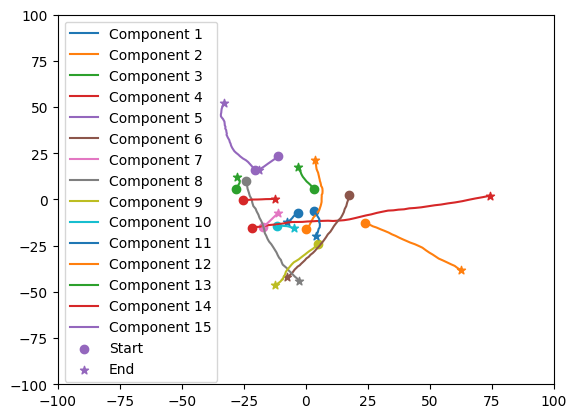

In [3]:
# generate ground truth data
F = create_state_matrix(dt, dim)
Q = np.identity(F.shape[0]) * 0.01

truths = simulate_motion(F, Q, num_steps=num_steps, birth_prob=birth_prob, death_prob=death_prob, pos_bounds=pos_bounds, vel_bounds=vel_bounds)
colors = []
for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    line = plt.plot(*pos[:,:2].T, label=f'Component {i + 1}')
    colors.append(line[0].get_color())
    plt.xlim(*area)
    plt.ylim(*area)
starts = []
ends = []
for i, state in truths.items():
    temp = [s for s in state if s is not None]
    starts.append(temp[0])
    ends.append(temp[-1])
print(starts)
for i, start in enumerate(starts):
    plt.scatter(*start[:2], marker='o', color=colors[i], label='Start')
for i, end in enumerate(ends):
    plt.scatter(*end[:2], marker='*', color=colors[i], label='End')

handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys())

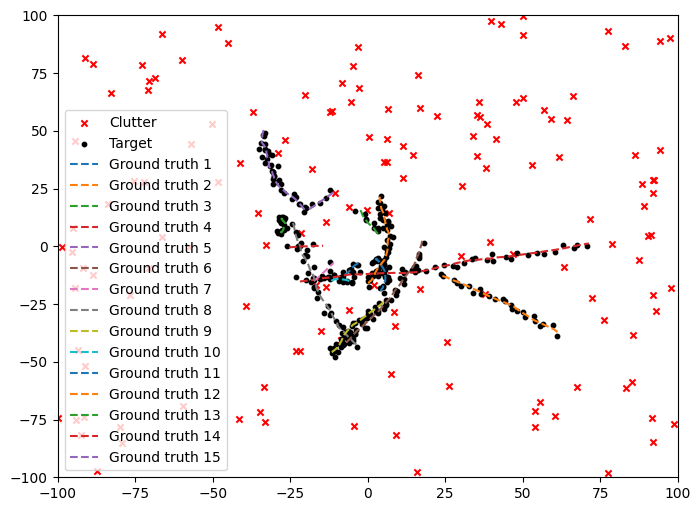

In [4]:
H = create_measurement_matrix(dim)
R = np.identity(H.shape[0]) * 0.75

all_measurements = simulate_measurement(truths, H, R, num_steps=num_steps, det_prob=det_prob, clutter_rate=clutter_rate, area=area)

# Setup
component_ids = sorted({i for measurements in all_measurements.values() for i, _ in measurements if i is not None})
num_steps = max(all_measurements.keys()) + 1

# Initialize trace for ground truths
trace_pos = {i: [] for i in truths}
all_clutter = []
all_target_measurements = []

for step in range(num_steps):
    measurements = all_measurements.get(step, [])

    # Accumulate measurements
    for i, measurement in measurements:
        if i is None:
            all_clutter.append(measurement)
        else:
            all_target_measurements.append((i, measurement))

    # Update ground truth traces
    for i, state in truths.items():
        if state[step] is not None:
            trace_pos[i].append(state[step][:2])
        else:
            trace_pos[i].append([np.nan, np.nan])

    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    # Plot all clutter points so far
    if all_clutter:
        clutter_array = np.array(all_clutter)
        plt.scatter(clutter_array[:, 0], clutter_array[:, 1], c='red', marker='x', label='Clutter', s=20)

    # Plot all target measurements so far
    for i in component_ids:
        points = [m for j, m in all_target_measurements if j == i]
        if points:
            pts = np.array(points)
            plt.scatter(pts[:, 0], pts[:, 1], color='black', label='Target', s=10)

    # Plot ground truth trajectories
    for i, pos_list in trace_pos.items():
        pos = np.array(pos_list)
        plt.plot(pos[:, 0], pos[:, 1], linestyle='dashed', label=f'Ground truth {i + 1}')

    # Clean up legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    plt.legend(unique.values(), unique.keys())

    plt.xlim(*area)
    plt.ylim(*area)
    plt.show()

    time.sleep(0.05)

In [5]:
print("F")
print(F)
print("Q")
print(Q)
print("H")
print(H)
print("R")
print(R)

F
[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Q
[[0.01 0.   0.   0.  ]
 [0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.  ]
 [0.   0.   0.   0.01]]
H
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]]
R
[[0.75 0.  ]
 [0.   0.75]]


In [6]:
# get initial truths
init_truths = []
for states in truths.values():
    if states[0] is not None:
        init_truths.append(states[0])
    
init_truths = np.array(init_truths)

num_components = len(init_truths)

# assume each component has the same weight
component_weight = 1e-3

# the variance of pos and vel
pos_var = 10
vel_var = 5

# each component assumed to start at a random (x, y) ~ U([-50, 50] x [-50, 50])
start_bounds = (-50, 50)

w = [component_weight] * num_components
# m = init_truths.copy()
m = []
for i in range(num_components):
    # m.append(np.random.uniform(start_bounds[0], start_bounds[1], size=(dim,)))
    m.append(np.array([
            *np.random.uniform(*start_bounds, 2),
            # initial velocity (dx, dy) ~ U(-2, 2) x U(-2, 2)
            0, 
            0
    ]))
m = np.array(m)
P = np.array([np.diag([pos_var, pos_var, vel_var, vel_var])**2 for _ in range(num_components)])

In [7]:
print("Initial weights:")
print(w)
print("Initial means:")
print(m)
print("Initial covariances:")
print(P)

Initial weights:
[0.001, 0.001, 0.001]
Initial means:
[[  5.25527523 -17.4607472    0.           0.        ]
 [ 17.2949616  -12.88476748   0.           0.        ]
 [ 11.44181457  20.31613343   0.           0.        ]]
Initial covariances:
[[[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]

 [[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]

 [[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]]


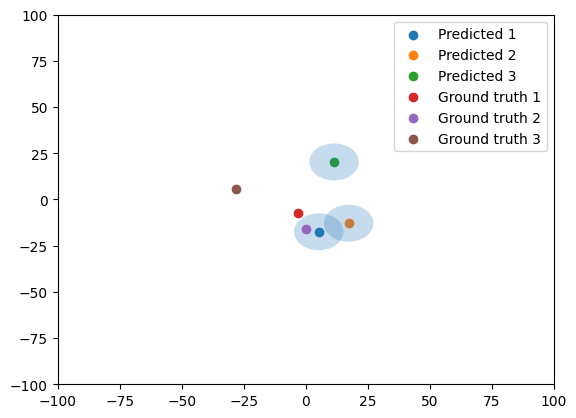

In [8]:
fig, ax = plt.subplots()
for i in range(len(w)):
    pos = m[i][:2]
    cov = P[i][:2, :2]
    eigvals, eigvecs = np.linalg.eig(cov)
    a = eigvals.argsort()[::-1]
    eigvals = eigvals[a]
    unc = patches.Ellipse(pos, 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=0, alpha=0.25)
    ax.scatter(pos[0], pos[1], label=f'Predicted {i + 1}')
    ax.add_patch(unc)
    ax.set_xlim(*area)
    ax.set_ylim(*area)

for i in range(len(init_truths)):
    pos = init_truths[i][:2]
    ax.scatter(*pos, label=f'Ground truth {i + 1}')
plt.legend()

In [9]:
# initialize the filter
filter = mtt_phd(
    weights=w,
    position=m,
    p_cov=P,
    num_components=num_components,
    measurement=all_measurements,
    state_transition_matrix=F,
    process_noise_matrix=Q,
    measurement_matrix=H,
    measurement_noise=R,
    num_steps=len(all_measurements),
    detection_probability=det_prob,
    clutter_intensity=clutter_rate/(area[1] - area[0])**2,
    merging_threshold = 5.0,
    truncation_threshold = 1e-8, # make sure squared
    threshold_weight= 0.1,
    new_birth_weight=0.25,
    survival_prob=0.995,
    max_components=100,
)

In [10]:
history = filter.run()

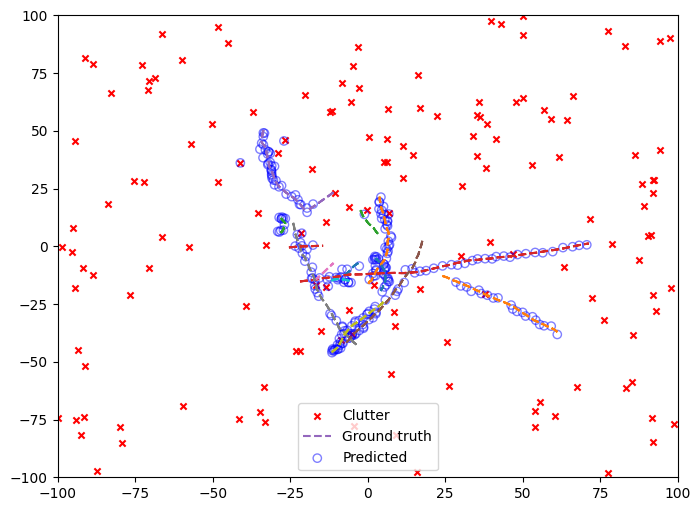

In [11]:
# pos = []
all_clutter = []
all_pos = []

for step in range(num_steps):
    measurements = all_measurements.get(step, [])
    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    for j, state in enumerate(history[step]):
        if state is not None:
            pos = state[:2]
            all_pos.append(pos)
        else:
            all_pos.append([np.nan, np.nan])
            
    for i, measurement in measurements:
        if i is None:
            all_clutter.append(measurement)

    # Update ground truth traces
    for i, state in truths.items():
        if state[step] is not None:
            trace_pos[i].append(state[step][:2])
        else:
            trace_pos[i].append([np.nan, np.nan])

    # Plot all clutter points so far
    if all_clutter:
        clutter_array = np.array(all_clutter)
        plt.scatter(clutter_array[:, 0], clutter_array[:, 1], c='red', marker='x', label='Clutter', s=20)

    # Plot ground truth trajectories
    for i, pos_list in trace_pos.items():
        pos = np.array(pos_list)
        plt.plot(pos[:, 0], pos[:, 1], linestyle='dashed', label=f'Ground truth')

    for p in all_pos:
        plt.scatter(*p, facecolors='none', edgecolors='blue', alpha=0.5, label='Predicted')

    # Clean up legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    plt.legend(unique.values(), unique.keys())

    plt.xlim(*area)
    plt.ylim(*area)
    plt.show()

    time.sleep(0.05)

In [12]:
# pos = []
# for state in history.values():
#     if len(state) > 0:
#         pos.append(state[0][:2])
# pos = np.array(pos)
# plt.scatter(*pos.T, facecolors='none', edgecolors='blue', alpha=0.5)
# plt.xlim(*area)
# plt.ylim(*area)

# for i, state in truths.items():
#     pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
#     plt.plot(*pos[:,:2].T, linestyle='dashed', label=f'Ground truth')

# for measurements in all_measurements.values():
#     for i, measurement in measurements:
#         if i is None:
#             plt.scatter(measurement[0], measurement[1], c='red', marker='x', label='Clutter', s=20)

# handles, labels = plt.gca().get_legend_handles_labels()
# unique = dict(zip(labels, handles))
# order = np.argsort(list(unique.keys()))
# plt.legend([list(unique.values())[i] for i in order], [list(unique.keys())[i] for i in order])